# Modelling RSNA Mammographic Dataset with Tensorflow

Author: Amir Fawwaz

Affliation: Twistcode® Technologies Sdn. Bhd., Cyberjaya, Malaysia

Published: 31 December 2022

## Introduction
This dataset is taken from [kaggle](https://www.kaggle.com/competitions/rsna-breast-cancer-detection/overview)

## Objective
Since the dataset is quite big (which is in DICOM format), we would like to pre-processing it to:

+ single pickle file (or any other suitable format)

to ease the machine learning modeling afterwards. However, in this example, we only use a sample from the original dataset.

## Dataset Description

Metadata for each patient and image. Only the first few rows of the test set are available for download.

+ site_id - ID code for the source hospital.
+ patient_id - ID code for the patient.
+ image_id - ID code for the image.
+ laterality - Whether the image is of the left or right breast.
+ view - The orientation of the image. The default for a screening exam is to capture two views per breast.
+ age - The patient's age in years.
+ implant - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.
+ density - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.
+ machine_id - An ID code for the imaging device.
+ cancer - Whether or not the breast was positive for malignant cancer. The target value. Only provided for train.
+ biopsy - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.
+ invasive - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.
+ BIRADS - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.
+ prediction_id - The ID for the matching submission row. Multiple images will share the same prediction ID. Test only.
+ difficult_negative_case - True if the case was unusually difficult. Only provided for train.

## A bit on DICOM


+ Pixel Depth: is the number of bits used to encode the information of each pixel. For example, an 8-bit raster can have 256 unique values that range from 0 to 255.

+ Photometric Interpretation: specifies how the pixel data should be interpreted for the correct image display as a monochrome or color image. To specify if the color information is or is not stored in the image pixel values, we introduce the concept of samples per pixel, also known as (number of channels).

+ Metadata: is the information that describes the image (i.e. patients ID, date of the image).

+ Pixel Data: is the section where the numerical values of the pixels are stored. All the components are essential but in our scope the pixel depth and pixel data. To my knowledge that ultrasound images are not an issue with converting the image to another format, but we have to look into consideration the depth of the image since _**we cannot convert 16-bit DICOM image to JPEG or PNG with 8-bit that might corrupt the image quality and image features**_. Pixel data the data that we are going to feed it to the network.

## Analysis setup
Preliminary analysis in this report was derive from small sample data.

This report is generated using Jupyterlab which runs on Windows 11 Pro with the following specification:

+ Intel Core i7-8700K, 3.7 GHz (6 cores)
+ 32 GiB, Corsair DDR4 (1066MHz)
+ NVMe (SSD Micron MTFDDAV512TBN)
+ Nvidia RTX 2080 Ti

+ python 3.7.9
+ CUDA 10.0
+ cuDNN 7.6.5.32

In [1]:
!pip install -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg pydicom python-gdcm

  Using cached pylibjpeg-1.4.0-py3-none-any.whl (28 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.9 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached pylibjpeg_libjpeg-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
  Using cached pydicom-2.3.1-py3-none-any.whl (2.0 MB)
  Using cached python_gdcm-3.0.20-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)


## DataSet Exploratory Data Analysis (EDA)

In [4]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
from termcolor import colored
from tqdm import tqdm
from glob import glob
from pathlib import Path
from IPython.display import clear_output, display_html

import os
import pydicom
import cv2
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from keras import metrics
from tensorflow.keras.optimizers import Adam

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

2023-01-01 23:53:02.982035: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-01 23:53:03.255691: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-01 23:53:04.421081: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/twistcode/Downloads/guasukalu/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64
2023-01-01 23:53:04.421162: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not lo

In [5]:
def load_data():
    '''Load each of the datasets we are given.'''
    
    data_dir = Path("rsna-breast-cancer-detection")
    dir_up_ = Path(data_dir).parents[0]
    train = pd.read_csv(dir_up_ / "train.csv")
    test = pd.read_csv(dir_up_ / "test.csv")
    sample_submission = pd.read_csv(dir_up_ / 'sample_submission.csv')
    # return train, test
    return train, test, sample_submission


def data_info(csv, name="Train"):
    '''Prints basic information about the datasets we are given.'''
    '''Inspired by: https://www.kaggle.com/code/andradaolteanu/rsna-fracture-detection-dicom-images-explore'''
    
    print(colored('==== {} ===='.format(name), 'cyan', attrs=['bold']))
    print(colored('Shape: ', 'cyan', attrs=['bold']), csv.shape)
    print(colored('NaN Values: ', 'cyan', attrs=['bold']), csv.isnull().sum().sum(), '\n')
    #print(colored('Columns: ', 'blue', attrs=['bold']), list(csv.columns))
    
    display_html(csv.head())
    if name != 'Sample Submission': print("\n")


train, test, sample_submission = load_data()
clear_output()


names = ["Train", "Test", "Sample Submission"]
for i, df in enumerate([train, test, sample_submission]): 
    data_info(df, names[i])

==== Train ====
Shape:  (54706, 14)
NaN Values:  53693 



,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True




==== Test ====
Shape:  (4, 9)
NaN Values:  0 



,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R




==== Sample Submission ====
Shape:  (2, 2)
NaN Values:  0 



,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


### Early Insight about Data

+ In the metadata training file we have plenty of missing values.
+ Repeated values for patient_id. It seems that for each patient, 4 images have been taken.
+ Some features from the training set do not appear in the testing one.

In order to make a proper analysis, we're gonna load every metadata from the images into a dataframe. Some of this data may be useful afterwards for the model training and splitting strategies.

In [6]:
df1 = train[train['cancer']==0]
print(len(df1))
df1.head()

53548


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [7]:
df2 = train[train['cancer']==1]
print(len(df2))
df2.head()

1158


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
87,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False
88,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False
89,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False
90,1,10130,1672636630,L,MLO,71.0,1,1,1,0.0,0,B,49,False
190,1,10226,461614796,L,MLO,71.0,1,1,1,0.0,0,C,49,False


In [8]:
healthy_patient_id_list = df1['patient_id'].tolist()
cancer_patient_id_list = df2['patient_id'].tolist()

# dump a list to the pickle
with open ('cancer_list.pickle', 'wb') as pick:
    pickle.dump(cancer_patient_id_list, pick)
    
with open ('healthy_list.pickle', 'wb') as pick:
    pickle.dump(healthy_patient_id_list, pick)

In [10]:
len(cancer_patient_id_list), len(healthy_patient_id_list)

(1158, 53548)

In [11]:
healthy_patient_id_list_clean = list(dict.fromkeys(healthy_patient_id_list))
len(healthy_patient_id_list_clean)

11907

In [12]:
cancer_patient_id_list_clean = list(dict.fromkeys(cancer_patient_id_list))
len(cancer_patient_id_list_clean)

486

In [14]:
healthy_paths = []
cancer_paths =  []

for f in tqdm(glob('rsna-breast-cancer-detection/cancer_paths/*')):
    id = f.split('/')[1] # this may change in linux
    cancer_paths.append(id)

for f in tqdm(glob('rsna-breast-cancer-detection/healthy_paths/*')):
    id = f.split('/')[1] # this may change in linux
    healthy_paths.append(id)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11907/11907 [00:00<00:00, 690143.96it/s]


In [15]:
len(healthy_paths), len(cancer_paths)

(11907, 486)

## Data preparation for Tensorflow

In [16]:
%%time

X_train = []
Y_train = []

healthy_paths = 'rsna-breast-cancer-detection/healthy_paths'
cancer_paths = 'rsna-breast-cancer-detection/cancer_paths/'

filelist_healthy = []
filelist_cancer = []

for root, dirs, files in os.walk(healthy_paths):
	for file in files:
        #append the file name to the list
		filelist_healthy.append(os.path.join(root,file))

for root, dirs, files in os.walk(cancer_paths):
	for file in files:
        #append the file name to the list
		filelist_cancer.append(os.path.join(root,file))
        
        
#print all the file names
for name in filelist_healthy:
    # print(name)
    ds = pydicom.dcmread(name)
    pixel_array_numpy = ds.pixel_array
    pixel_array_numpy = cv2.resize(pixel_array_numpy, dsize=(256, 256))
    
    X_train.append(pixel_array_numpy)
    Y_train.append(0)
    # print(len(X_train))
    # plt.imshow(pixel_array_numpy, cmap='gray')
    #plt.show()
    

#print all the file names
for name_ in filelist_cancer:
    # print(name)
    ds = pydicom.dcmread(name_)
    pixel_array_numpy = ds.pixel_array
    pixel_array_numpy = cv2.resize(pixel_array_numpy, dsize=(256, 256))
    
    X_train.append(pixel_array_numpy)
    Y_train.append(1)
    # print(len(X_train))
    # plt.imshow(pixel_array_numpy, cmap='gray')
    #plt.show()

CPU times: user 11h 34min 15s, sys: 1h 17min 27s, total: 12h 51min 43s
Wall time: 5h 42min 12s


In [17]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# check shape
# X_train = np.expand_dims(X_train,-1)
# X_train.shape

In [18]:
X_train.shape,Y_train.shape

((56962, 256, 256), (56962,))

In [19]:
from numpy import save
save('X_train.npy', X_train)
save('Y_train.npy', Y_train)

In [20]:
### Tensorflow CNN

In [21]:
model = Sequential()
input_shape = (256, 256, 1)

model.add(Conv2D(filters=32, kernel_size = (3,3), strides =1, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =1, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size = (3,3), strides =1, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=256, kernel_size = (3,3), strides =1, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.13))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.13))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1 , activation="sigmoid"))
model.summary()

2023-01-02 09:26:20.921378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 09:26:39.147246: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3105 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 980, pci bus id: 0000:01:00.0, compute capability: 5.2


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

In [22]:
def tf_pfbeta(from_logits=True, beta=1.0, epsilon=1e-07):
    
    def pfbeta(y_true, y_pred):
        y_pred = tf.cond(
            tf.cast(from_logits, dtype=tf.bool),
            lambda: tf.nn.sigmoid(y_pred),
            lambda: y_pred,
        )
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        ctp = tf.reduce_sum(y_true * y_pred, axis=-1)
        cfp = tf.reduce_sum(y_pred, axis=-1) - ctp

        c_precision = ctp / (ctp + cfp)
        c_recall = ctp / tf.reduce_sum(y_true)
        
        def compute_fractions():
            numerator = c_precision * c_recall
            denominator = beta**2 * c_precision + c_recall
            return (1 + beta**2) * tf.math.divide_no_nan(numerator, denominator)
        
        return tf.cond(
            tf.logical_and(
                tf.greater(c_precision, 0.), tf.greater(c_recall, 0.)
            ),
            compute_fractions,
            lambda: tf.constant(0, dtype=tf.float32)
        )
    
    return pfbeta

def tf_auc(from_logits=True):
    auc_fn = metrics.AUC()
    
    def auc(y_true, y_pred):
        y_pred = tf.cond(
            tf.cast(from_logits, dtype=tf.bool),
            lambda: tf.nn.sigmoid(y_pred),
            lambda: y_pred,
        )
        return auc_fn(y_true, y_pred)
    
    return auc


def weighted_binary_loss(weight, from_logits=True, reduction="mean"):
    def inverse_sigmoid(sigmoidal):
        return - tf.math.log(1. / sigmoidal - 1.)

    def weighted_loss(labels, predictions):
        predictions = tf.convert_to_tensor(predictions)
        labels = tf.cast(labels, predictions.dtype)
        num_samples = tf.cast(tf.shape(labels)[-1], dtype=labels.dtype)

        logits = tf.cond(
            tf.cast(from_logits, dtype=tf.bool),
            lambda: predictions,
            lambda: inverse_sigmoid(sigmoidal=predictions),
        )
        loss = tf.nn.weighted_cross_entropy_with_logits(
            tf.cast(labels, dtype=tf.float32), logits, pos_weight=weight
        )
        
        if reduction.lower() == "mean":
            return tf.reduce_mean(loss)
        elif reduction.lower() == "sum":
            return tf.reduce_sum(loss) / num_samples
        elif reduction.lower() == "none":
            return loss
        else:
            raise ValueError(
                'Reduction type is should be `mean` or `sum` or `none`. ',
                f'But, received {reduction}'
            )
    return weighted_loss

def binary_focal_loss(
    alpha=0.25, 
    gamma=2.0, 
    label_smoothing=0, 
    from_logits=False,
    apply_class_balancing=False,
    apply_positive_weight=1,
    reduction="mean"
):
    '''
    alpha: A weight balancing factor for class 1, default is 0.25. 
        The weight for class 0 is 1.0 - alpha.
    
    gamma: A focusing parameter used to compute the focal factor, default is 2.0
    
    apply_class_balancing: A bool, whether to apply weight balancing on the binary 
        classes 0 and 1.
    '''
    
    def smooth_labels(labels):
        return labels * (1.0 - label_smoothing) + 0.5 * label_smoothing
    
    def compute_loss(labels, logits):
        logits = tf.convert_to_tensor(logits)
        labels = tf.cast(labels, logits.dtype)
        labels = tf.cond(
            tf.cast(label_smoothing, dtype=tf.bool),
            lambda: smooth_labels(labels),
            lambda: labels,
        )
        num_samples = tf.cast(tf.shape(labels)[-1], dtype=labels.dtype)
        cross_entropy = weighted_binary_loss(
            apply_positive_weight, from_logits, reduction='none'
        )(labels, logits)
        
        sigmoidal = tf.cond(
            tf.cast(from_logits, dtype=tf.bool),
            lambda: tf.nn.sigmoid(logits),
            lambda: logits,
        )
        pt = labels * sigmoidal + (1.0 - labels) * (1.0 - sigmoidal)
        focal_factor = tf.pow(1.0 - pt, gamma)
        focal_bce =  focal_factor * cross_entropy
        
        if apply_class_balancing:
            weight = labels * alpha + (1 - labels) * (1 - alpha)
            focal_bce = weight * focal_bce

        if reduction == 'mean':
            return tf.reduce_mean(focal_bce)
        elif reduction == 'sum':
            return tf.reduce_sum(focal_bce) / num_samples
        else:
            raise ValueError(
                'Reduction type should be `mean` or `sum` ',
                f'But, received {reduction}'
            )
    return compute_loss

In [23]:
model.compile(loss='binary_crossentropy',
              
            optimizer=Adam(lr=0.001),metrics = [
            tf_pfbeta(beta=1.0, from_logits=True),
            tf_auc(from_logits=True)
        ])

/home/twistcode/Downloads/guasukalu/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

In [25]:
print(y_train.dtype)

int64


In [26]:
%time history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=100, batch_size=64)

2023-01-02 09:27:21.317358: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5972819968 exceeds 10% of free system memory.
2023-01-02 09:27:33.913950: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.56GiB (rounded to 5972819968)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-01-02 09:27:33.914000: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2023-01-02 09:27:33.914024: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 26, Chunks in use: 26. 6.5KiB allocated for chunks. 6.5KiB in use in bin. 880B client-requested in use in bin.
2023-01-02 09:27:33.914044: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 2, C

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [18]:
# save model
model.save('rsna_100_tetek.h5')
print('Model Saved!')

Model Saved!


## Tensorflow Training Result

In [19]:
model.evaluate(x_test,y_test)

6/6 [==============================] - 1s 91ms/step - loss: 1.2595 - pfbeta: 0.5685 - auc: 0.8846


[1.259546160697937, 0.5684840083122253, 0.8846395611763]

1/1 [==============================] - 0s 209ms/step
[[0.7050069]]


1

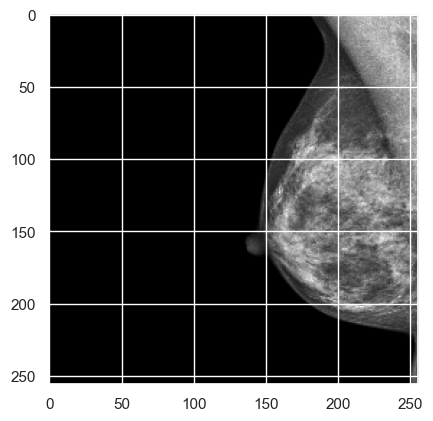

In [20]:
index = 50
print(model.predict(np.expand_dims(x_test[index],0)))
plt.imshow(x_train[index], cmap='gray')
y_test[index]

In [21]:
# def preprocess(file_path):
#     ds = pydicom.dcmread(i)
#     pixel_array_numpy = ds.pixel_array
#     pixel_array_numpy = cv2.resize(pixel_array_numpy, dsize=(256, 256))
#     pixel_array_numpy = np.expand_dims(pixel_array_numpy,-1)
#     return pixel_array_numpy 

In [22]:
# test = []

# for i in glob('/kaggle/input/rsna-breast-cancer-detection/test_images/10008/*'):
#             output = preprocess(i)
#             test.append(output)
# test = np.array(test)
# test.shape

In [23]:
# preds = model.predict(test)
# preds

## Reference

1. https://www.kaggle.com/code/ahmedhossam666/rsna-breast
2. https://www.kaggle.com/code/javigallego/rsna-complete-eda-external-data